# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'
import numpy as np
import pickle as pkl

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

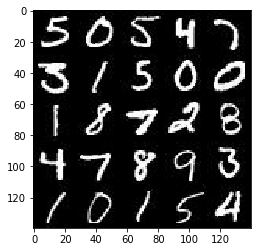

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

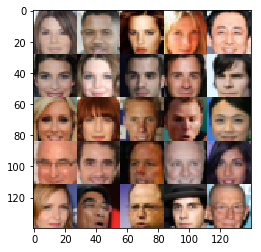

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.1
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name = 'real_input')
    z_input = tf.placeholder(tf.float32, (None, z_dim), name='z_input')
    learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope("discriminator", reuse = reuse):
        ### Images: batch x 28 x 28 x n_channels
        h1 = tf.layers.conv2d(images, 64, 5, strides = 2, padding = 'same', activation = None)
        relu1 = tf.maximum(0.2*h1, h1)
        # Relu1 has shape 14x14x64
        # Note: in the first layer we use DCGan paper advise and don't use batch normalization.
        
        h2 = tf.layers.conv2d(relu1, 128, 5, strides = 2, padding = 'same', activation = None)
        b2 = tf.layers.batch_normalization(h2, training = True)
        relu2 = tf.maximum(0.2*b2, b2)
        # Layer output shape = 7 x 7 x 128
        
        h3 = tf.layers.conv2d(relu2, 256, 5, strides = 2, padding = 'same', activation = None)
        b3 = tf.layers.batch_normalization(h3, training = True)
        relu3 = tf.maximum(0.2*b3, b3)
        # output shape = 4 x 4 x 256
        
        flatten = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flatten, 1)
        output = tf.nn.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    with tf.variable_scope('generator', reuse = not is_train):
        # First layer
        x1 = tf.layers.dense(z, (7*7*512), activation = None)
        x1 = tf.reshape(x1, (-1, 7,7,512))
        x1 = tf.layers.batch_normalization(x1, training = is_train)
        x1 = tf.maximum(0.2*x1,x1)
        
        # Second layer
        x2 = tf.layers.conv2d_transpose(x1, 64, 5, strides = 2, padding = 'same', activation = None)
        x2 = tf.layers.batch_normalization(x2, training = is_train)
        x2 = tf.maximum(0.2*x2,x2)
        
        # Third layer
        x3 = tf.layers.conv2d_transpose(x2, 32, 5, strides = 2, padding = 'same', activation = None)
        x3 = tf.layers.batch_normalization(x3, training = is_train)
        x3 = tf.maximum(0.2*x3,x3)
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides = 1, padding = 'same')
        out = tf.nn.tanh(logits)
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    # Generate fake images
    input_fake = generator(input_z, out_channel_dim, is_train = True)

    # Compute Discriminator output for Real and Fake Images
    d_real_output, d_real_logits = discriminator(input_real, reuse = False) # with reuse = False we start a new variable scope
    d_fake_output, d_fake_logits = discriminator(input_fake, reuse = True) # but for the fake images we actually want to re-use the same scope

    # Discriminator Loss
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_real_logits, labels =np.random.uniform(0.7,1.2)*tf.ones_like(d_real_output))
    )
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_fake_logits, labels = tf.zeros_like(d_fake_output))
    )

    d_loss = d_loss_fake + d_loss_real

    # Generator loss
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits = d_fake_logits, labels = tf.ones_like(d_fake_output))
    )
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
        # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    # Building the network.
    # First of all reset the TF Graph
    #tf.reset_default_graph()
    
    # Create the inputs
    image_width = data_shape[1]
    image_height = data_shape[2]
    image_channels = data_shape[3]
    
    real_input, z_input, lr_placeholder = model_inputs(image_width, image_height, image_channels, z_dim)
    
    # Create loss functions
    out_channel_dim = data_shape[3]
    d_loss, g_loss = model_loss(real_input, z_input, out_channel_dim)
    
    # Create loss optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, lr_placeholder, beta1)
    
    
    saver = tf.train.Saver()
    step = 0
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                batch_images = batch_images * 2
                step += 1
                #batch_z = np.random.normal(0,0.25, size = (batch_size, z_dim))
                batch_z = np.random.uniform(-1,1, size = (batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={real_input: batch_images, z_input: batch_z, lr_placeholder:learning_rate})
                _ = sess.run(g_opt, feed_dict={real_input: batch_images, z_input: batch_z, lr_placeholder:learning_rate})
            
                # Print and save losses at end of the first batch and then every 10th batch
                if (step % 10 == 0 or step == 1):
                        # At the end of each epoch, get the losses and print them out
                        train_loss_d = d_loss.eval({z_input: batch_z, real_input: batch_images})
                        train_loss_g = g_loss.eval({z_input: batch_z, real_input: batch_images})

                        print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                              "Discriminator Loss: {:.4f}...".format(train_loss_d),
                              "Generator Loss: {:.4f}".format(train_loss_g))
                
                # Show generated images at end of the first batch and then every 100th batch
                if (step % 100 == 0 or step == 1):
                    show_generator_output(sess, 25, z_input, out_channel_dim, data_image_mode)
    print("Final Output")
    show_generator_output(sess, 25, z_input, out_channel_dim, data_image_mode)
    #saver.save(sess, './checkpoints/generator.ckpt')
    return True

            
                                        

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.5261... Generator Loss: 0.5380


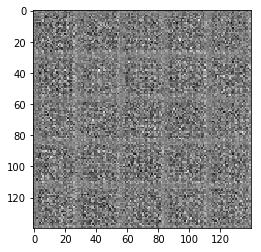

Epoch 1/2... Discriminator Loss: 1.4762... Generator Loss: 0.7582
Epoch 1/2... Discriminator Loss: 2.0589... Generator Loss: 3.7537
Epoch 1/2... Discriminator Loss: 2.4225... Generator Loss: 0.2175
Epoch 1/2... Discriminator Loss: 1.5189... Generator Loss: 0.7004
Epoch 1/2... Discriminator Loss: 1.3940... Generator Loss: 1.1766
Epoch 1/2... Discriminator Loss: 1.3925... Generator Loss: 0.7708
Epoch 1/2... Discriminator Loss: 1.3631... Generator Loss: 0.6367
Epoch 1/2... Discriminator Loss: 1.6258... Generator Loss: 0.4192
Epoch 1/2... Discriminator Loss: 1.4161... Generator Loss: 1.0723
Epoch 1/2... Discriminator Loss: 1.6153... Generator Loss: 0.4240


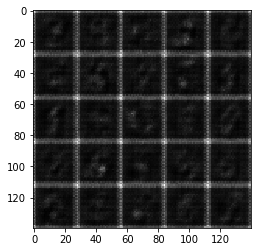

Epoch 1/2... Discriminator Loss: 1.2841... Generator Loss: 0.8382
Epoch 1/2... Discriminator Loss: 1.3043... Generator Loss: 0.8738
Epoch 1/2... Discriminator Loss: 1.1325... Generator Loss: 0.9699
Epoch 1/2... Discriminator Loss: 1.0767... Generator Loss: 1.0332
Epoch 1/2... Discriminator Loss: 1.2315... Generator Loss: 0.8605
Epoch 1/2... Discriminator Loss: 1.0307... Generator Loss: 1.2097
Epoch 1/2... Discriminator Loss: 1.2008... Generator Loss: 0.8246
Epoch 1/2... Discriminator Loss: 1.1110... Generator Loss: 1.4199
Epoch 1/2... Discriminator Loss: 1.1862... Generator Loss: 1.9284
Epoch 1/2... Discriminator Loss: 1.3106... Generator Loss: 1.7156


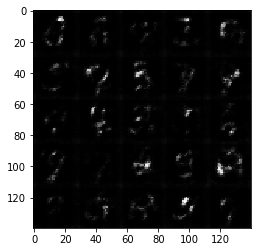

Epoch 1/2... Discriminator Loss: 1.0936... Generator Loss: 1.3310
Epoch 1/2... Discriminator Loss: 1.0386... Generator Loss: 0.9523
Epoch 1/2... Discriminator Loss: 0.9738... Generator Loss: 1.2423
Epoch 1/2... Discriminator Loss: 0.9975... Generator Loss: 1.5487
Epoch 1/2... Discriminator Loss: 0.9973... Generator Loss: 1.1025
Epoch 1/2... Discriminator Loss: 0.8610... Generator Loss: 1.5676
Epoch 1/2... Discriminator Loss: 0.8095... Generator Loss: 1.3668
Epoch 1/2... Discriminator Loss: 0.8740... Generator Loss: 1.1430
Epoch 1/2... Discriminator Loss: 0.9271... Generator Loss: 1.1955
Epoch 1/2... Discriminator Loss: 0.9189... Generator Loss: 1.9589


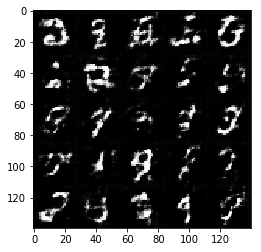

Epoch 1/2... Discriminator Loss: 0.9304... Generator Loss: 1.4118
Epoch 1/2... Discriminator Loss: 0.9925... Generator Loss: 1.0191
Epoch 1/2... Discriminator Loss: 0.9998... Generator Loss: 2.1282
Epoch 1/2... Discriminator Loss: 1.3300... Generator Loss: 0.5893
Epoch 1/2... Discriminator Loss: 1.1501... Generator Loss: 0.7936
Epoch 1/2... Discriminator Loss: 1.0341... Generator Loss: 1.0701
Epoch 1/2... Discriminator Loss: 1.3298... Generator Loss: 0.6277
Epoch 1/2... Discriminator Loss: 1.0279... Generator Loss: 1.9513
Epoch 1/2... Discriminator Loss: 0.9449... Generator Loss: 1.4661
Epoch 1/2... Discriminator Loss: 1.0176... Generator Loss: 1.4083


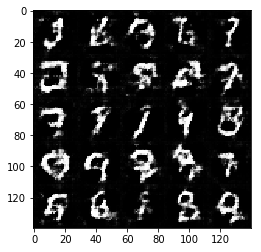

Epoch 1/2... Discriminator Loss: 1.1197... Generator Loss: 0.8312
Epoch 1/2... Discriminator Loss: 1.0664... Generator Loss: 1.4569
Epoch 1/2... Discriminator Loss: 1.3081... Generator Loss: 0.6089
Epoch 1/2... Discriminator Loss: 1.1545... Generator Loss: 0.8064
Epoch 1/2... Discriminator Loss: 1.1293... Generator Loss: 0.8693
Epoch 1/2... Discriminator Loss: 1.1985... Generator Loss: 0.7357
Epoch 1/2... Discriminator Loss: 1.3132... Generator Loss: 0.6452
Epoch 1/2... Discriminator Loss: 1.2264... Generator Loss: 0.7318
Epoch 1/2... Discriminator Loss: 1.0628... Generator Loss: 0.9568
Epoch 1/2... Discriminator Loss: 1.8116... Generator Loss: 0.3398


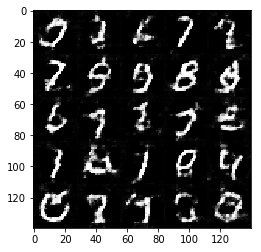

Epoch 1/2... Discriminator Loss: 0.9486... Generator Loss: 1.3342
Epoch 1/2... Discriminator Loss: 1.2832... Generator Loss: 0.6522
Epoch 1/2... Discriminator Loss: 1.2573... Generator Loss: 0.6519
Epoch 1/2... Discriminator Loss: 0.9817... Generator Loss: 1.5624
Epoch 1/2... Discriminator Loss: 1.0803... Generator Loss: 1.0242
Epoch 1/2... Discriminator Loss: 1.0968... Generator Loss: 1.0611
Epoch 1/2... Discriminator Loss: 1.5472... Generator Loss: 2.0531
Epoch 1/2... Discriminator Loss: 1.1490... Generator Loss: 0.8566
Epoch 1/2... Discriminator Loss: 1.0822... Generator Loss: 1.4840
Epoch 1/2... Discriminator Loss: 0.9977... Generator Loss: 0.9853


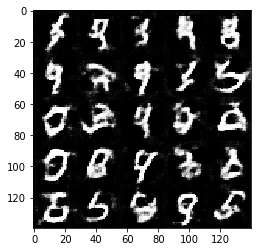

Epoch 1/2... Discriminator Loss: 1.3334... Generator Loss: 0.6415
Epoch 1/2... Discriminator Loss: 1.0703... Generator Loss: 1.2244
Epoch 1/2... Discriminator Loss: 0.9882... Generator Loss: 1.3185
Epoch 1/2... Discriminator Loss: 0.9952... Generator Loss: 1.3268
Epoch 1/2... Discriminator Loss: 1.1818... Generator Loss: 1.3652
Epoch 1/2... Discriminator Loss: 1.0283... Generator Loss: 1.4480
Epoch 1/2... Discriminator Loss: 1.1397... Generator Loss: 0.7895
Epoch 1/2... Discriminator Loss: 1.1518... Generator Loss: 0.9994
Epoch 1/2... Discriminator Loss: 1.0405... Generator Loss: 1.4176
Epoch 1/2... Discriminator Loss: 1.1353... Generator Loss: 0.8647


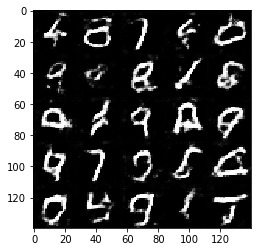

Epoch 1/2... Discriminator Loss: 1.0214... Generator Loss: 1.0353
Epoch 1/2... Discriminator Loss: 1.0470... Generator Loss: 1.0037
Epoch 1/2... Discriminator Loss: 1.0856... Generator Loss: 1.0598
Epoch 1/2... Discriminator Loss: 0.9824... Generator Loss: 1.0717
Epoch 1/2... Discriminator Loss: 1.1332... Generator Loss: 1.0615
Epoch 1/2... Discriminator Loss: 1.1136... Generator Loss: 0.8471
Epoch 1/2... Discriminator Loss: 1.1075... Generator Loss: 1.1793
Epoch 1/2... Discriminator Loss: 1.1186... Generator Loss: 0.8921
Epoch 1/2... Discriminator Loss: 1.2393... Generator Loss: 0.7179
Epoch 1/2... Discriminator Loss: 0.9701... Generator Loss: 1.2879


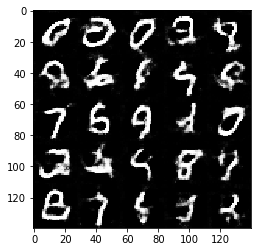

Epoch 1/2... Discriminator Loss: 1.1673... Generator Loss: 1.3506
Epoch 1/2... Discriminator Loss: 0.9264... Generator Loss: 1.4151
Epoch 1/2... Discriminator Loss: 1.1979... Generator Loss: 1.6115
Epoch 1/2... Discriminator Loss: 1.2659... Generator Loss: 1.3963
Epoch 1/2... Discriminator Loss: 1.1450... Generator Loss: 0.7513
Epoch 1/2... Discriminator Loss: 1.3551... Generator Loss: 0.5985
Epoch 1/2... Discriminator Loss: 1.0625... Generator Loss: 0.9947
Epoch 1/2... Discriminator Loss: 1.1290... Generator Loss: 0.8537
Epoch 1/2... Discriminator Loss: 1.0052... Generator Loss: 1.0754
Epoch 1/2... Discriminator Loss: 1.0646... Generator Loss: 0.9466


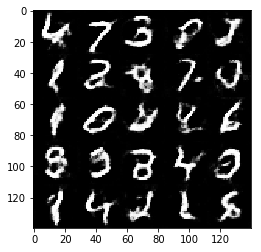

Epoch 1/2... Discriminator Loss: 0.8914... Generator Loss: 1.2208
Epoch 1/2... Discriminator Loss: 0.9702... Generator Loss: 1.3983
Epoch 1/2... Discriminator Loss: 1.0012... Generator Loss: 1.1762
Epoch 1/2... Discriminator Loss: 1.1304... Generator Loss: 0.9895
Epoch 1/2... Discriminator Loss: 1.0548... Generator Loss: 1.0476
Epoch 1/2... Discriminator Loss: 0.9593... Generator Loss: 1.3958
Epoch 1/2... Discriminator Loss: 1.0303... Generator Loss: 0.9253
Epoch 1/2... Discriminator Loss: 0.8959... Generator Loss: 1.2934
Epoch 1/2... Discriminator Loss: 1.0417... Generator Loss: 0.9295
Epoch 1/2... Discriminator Loss: 1.0269... Generator Loss: 1.0410


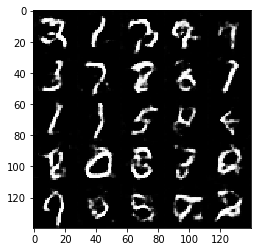

Epoch 1/2... Discriminator Loss: 0.9969... Generator Loss: 1.1502
Epoch 1/2... Discriminator Loss: 0.9510... Generator Loss: 1.3675
Epoch 1/2... Discriminator Loss: 0.8755... Generator Loss: 1.4070
Epoch 1/2... Discriminator Loss: 0.9996... Generator Loss: 0.9847
Epoch 1/2... Discriminator Loss: 1.5435... Generator Loss: 0.4623
Epoch 1/2... Discriminator Loss: 1.1594... Generator Loss: 1.5468
Epoch 1/2... Discriminator Loss: 0.9051... Generator Loss: 1.1534
Epoch 1/2... Discriminator Loss: 1.0738... Generator Loss: 0.9634
Epoch 1/2... Discriminator Loss: 1.0712... Generator Loss: 0.9312
Epoch 1/2... Discriminator Loss: 0.8060... Generator Loss: 1.5669


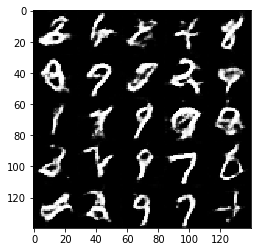

Epoch 1/2... Discriminator Loss: 1.0812... Generator Loss: 0.8318
Epoch 1/2... Discriminator Loss: 0.9876... Generator Loss: 1.1146
Epoch 1/2... Discriminator Loss: 1.0162... Generator Loss: 1.4399
Epoch 1/2... Discriminator Loss: 1.0342... Generator Loss: 0.9229
Epoch 1/2... Discriminator Loss: 0.9426... Generator Loss: 1.2696
Epoch 1/2... Discriminator Loss: 2.6902... Generator Loss: 4.4552
Epoch 1/2... Discriminator Loss: 1.0858... Generator Loss: 0.8769
Epoch 1/2... Discriminator Loss: 1.2140... Generator Loss: 0.6977
Epoch 1/2... Discriminator Loss: 0.8460... Generator Loss: 1.4742
Epoch 1/2... Discriminator Loss: 0.8847... Generator Loss: 1.3343


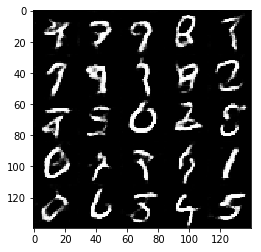

Epoch 1/2... Discriminator Loss: 0.8268... Generator Loss: 1.4519
Epoch 1/2... Discriminator Loss: 1.1843... Generator Loss: 0.7985
Epoch 1/2... Discriminator Loss: 1.1400... Generator Loss: 0.7441
Epoch 1/2... Discriminator Loss: 1.1316... Generator Loss: 0.8039
Epoch 1/2... Discriminator Loss: 1.0900... Generator Loss: 0.9644
Epoch 1/2... Discriminator Loss: 1.2154... Generator Loss: 0.6738
Epoch 1/2... Discriminator Loss: 1.0018... Generator Loss: 1.6830
Epoch 1/2... Discriminator Loss: 0.9282... Generator Loss: 1.3205
Epoch 1/2... Discriminator Loss: 0.8180... Generator Loss: 1.7503
Epoch 1/2... Discriminator Loss: 0.9693... Generator Loss: 0.9514


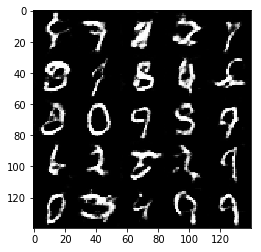

Epoch 1/2... Discriminator Loss: 0.8981... Generator Loss: 1.3743
Epoch 1/2... Discriminator Loss: 0.9679... Generator Loss: 1.0120
Epoch 1/2... Discriminator Loss: 1.1501... Generator Loss: 0.8275
Epoch 1/2... Discriminator Loss: 0.9116... Generator Loss: 1.6804
Epoch 1/2... Discriminator Loss: 1.2598... Generator Loss: 0.7091
Epoch 1/2... Discriminator Loss: 1.0859... Generator Loss: 0.8622
Epoch 1/2... Discriminator Loss: 0.9365... Generator Loss: 0.9751
Epoch 1/2... Discriminator Loss: 1.3399... Generator Loss: 0.7735
Epoch 1/2... Discriminator Loss: 0.8902... Generator Loss: 1.3231
Epoch 1/2... Discriminator Loss: 0.9693... Generator Loss: 1.3137


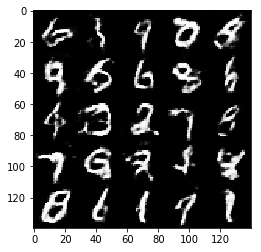

Epoch 1/2... Discriminator Loss: 1.1871... Generator Loss: 0.8925
Epoch 1/2... Discriminator Loss: 0.8679... Generator Loss: 1.1656
Epoch 1/2... Discriminator Loss: 0.9262... Generator Loss: 1.3587
Epoch 1/2... Discriminator Loss: 1.0071... Generator Loss: 0.9646
Epoch 1/2... Discriminator Loss: 0.9700... Generator Loss: 1.0866
Epoch 1/2... Discriminator Loss: 0.8919... Generator Loss: 1.3258
Epoch 1/2... Discriminator Loss: 0.8576... Generator Loss: 1.7296
Epoch 1/2... Discriminator Loss: 0.8683... Generator Loss: 1.1772
Epoch 1/2... Discriminator Loss: 1.0303... Generator Loss: 0.9065
Epoch 1/2... Discriminator Loss: 1.1831... Generator Loss: 0.7989


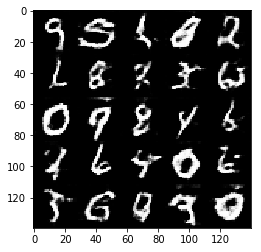

Epoch 1/2... Discriminator Loss: 1.0449... Generator Loss: 1.1692
Epoch 1/2... Discriminator Loss: 1.0906... Generator Loss: 0.8266
Epoch 1/2... Discriminator Loss: 1.1601... Generator Loss: 0.7018
Epoch 1/2... Discriminator Loss: 0.8208... Generator Loss: 1.3318
Epoch 1/2... Discriminator Loss: 0.9742... Generator Loss: 0.9899
Epoch 1/2... Discriminator Loss: 0.9772... Generator Loss: 1.0368
Epoch 1/2... Discriminator Loss: 0.8573... Generator Loss: 1.3382
Epoch 1/2... Discriminator Loss: 1.2003... Generator Loss: 0.6866
Epoch 1/2... Discriminator Loss: 0.9559... Generator Loss: 1.2709
Epoch 1/2... Discriminator Loss: 0.8967... Generator Loss: 1.2926


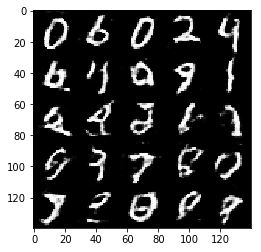

Epoch 1/2... Discriminator Loss: 1.0254... Generator Loss: 0.9366
Epoch 1/2... Discriminator Loss: 1.0792... Generator Loss: 1.8504
Epoch 1/2... Discriminator Loss: 1.0163... Generator Loss: 0.9519
Epoch 1/2... Discriminator Loss: 0.8756... Generator Loss: 1.3460
Epoch 1/2... Discriminator Loss: 1.5248... Generator Loss: 0.5040
Epoch 1/2... Discriminator Loss: 0.9563... Generator Loss: 1.1067
Epoch 1/2... Discriminator Loss: 0.9179... Generator Loss: 1.2039
Epoch 1/2... Discriminator Loss: 1.0395... Generator Loss: 0.9527
Epoch 1/2... Discriminator Loss: 0.9185... Generator Loss: 1.1757
Epoch 1/2... Discriminator Loss: 0.8614... Generator Loss: 1.5042


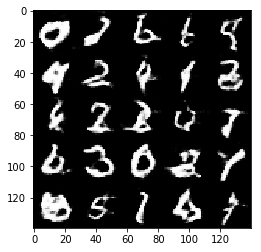

Epoch 1/2... Discriminator Loss: 0.7576... Generator Loss: 1.6751
Epoch 1/2... Discriminator Loss: 1.2894... Generator Loss: 0.6483
Epoch 1/2... Discriminator Loss: 1.8484... Generator Loss: 0.3439
Epoch 1/2... Discriminator Loss: 1.2829... Generator Loss: 0.6686
Epoch 1/2... Discriminator Loss: 0.9615... Generator Loss: 1.0475
Epoch 1/2... Discriminator Loss: 1.0333... Generator Loss: 0.9096
Epoch 1/2... Discriminator Loss: 0.8037... Generator Loss: 1.3914
Epoch 1/2... Discriminator Loss: 0.7941... Generator Loss: 1.5510
Epoch 1/2... Discriminator Loss: 1.1344... Generator Loss: 0.8943
Epoch 1/2... Discriminator Loss: 0.8597... Generator Loss: 1.3424


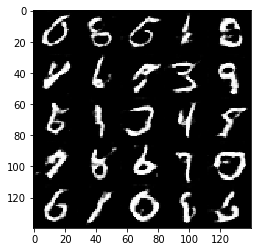

Epoch 1/2... Discriminator Loss: 0.9440... Generator Loss: 1.1154
Epoch 1/2... Discriminator Loss: 0.8168... Generator Loss: 1.6388
Epoch 1/2... Discriminator Loss: 1.0446... Generator Loss: 0.9401
Epoch 1/2... Discriminator Loss: 1.1430... Generator Loss: 1.7935
Epoch 1/2... Discriminator Loss: 1.1381... Generator Loss: 0.7886
Epoch 1/2... Discriminator Loss: 1.0339... Generator Loss: 0.8611
Epoch 1/2... Discriminator Loss: 0.9128... Generator Loss: 1.4053
Epoch 2/2... Discriminator Loss: 1.0926... Generator Loss: 0.8054
Epoch 2/2... Discriminator Loss: 0.7954... Generator Loss: 1.4895
Epoch 2/2... Discriminator Loss: 1.0046... Generator Loss: 1.0867


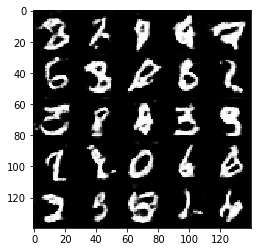

Epoch 2/2... Discriminator Loss: 0.7877... Generator Loss: 1.4630
Epoch 2/2... Discriminator Loss: 0.8350... Generator Loss: 1.4273
Epoch 2/2... Discriminator Loss: 0.9567... Generator Loss: 0.9758
Epoch 2/2... Discriminator Loss: 0.9766... Generator Loss: 0.9978
Epoch 2/2... Discriminator Loss: 1.5427... Generator Loss: 0.5530
Epoch 2/2... Discriminator Loss: 1.0227... Generator Loss: 0.8944
Epoch 2/2... Discriminator Loss: 0.9740... Generator Loss: 1.0252
Epoch 2/2... Discriminator Loss: 0.9491... Generator Loss: 1.1240
Epoch 2/2... Discriminator Loss: 0.9263... Generator Loss: 2.0090
Epoch 2/2... Discriminator Loss: 1.9302... Generator Loss: 0.3362


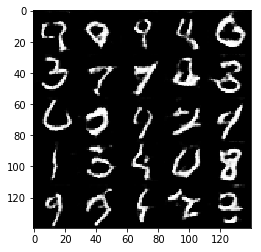

Epoch 2/2... Discriminator Loss: 0.6911... Generator Loss: 1.8869
Epoch 2/2... Discriminator Loss: 0.8867... Generator Loss: 1.8900
Epoch 2/2... Discriminator Loss: 0.8658... Generator Loss: 1.1772
Epoch 2/2... Discriminator Loss: 0.9240... Generator Loss: 1.1723
Epoch 2/2... Discriminator Loss: 0.8351... Generator Loss: 1.3504
Epoch 2/2... Discriminator Loss: 0.7383... Generator Loss: 1.4434
Epoch 2/2... Discriminator Loss: 0.9179... Generator Loss: 1.0832
Epoch 2/2... Discriminator Loss: 0.6948... Generator Loss: 1.6209
Epoch 2/2... Discriminator Loss: 0.8135... Generator Loss: 1.3363
Epoch 2/2... Discriminator Loss: 0.8122... Generator Loss: 1.2098


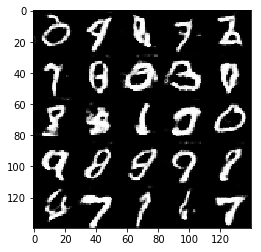

Epoch 2/2... Discriminator Loss: 0.8991... Generator Loss: 1.5430
Epoch 2/2... Discriminator Loss: 1.0747... Generator Loss: 1.0503
Epoch 2/2... Discriminator Loss: 0.9164... Generator Loss: 1.2120
Epoch 2/2... Discriminator Loss: 1.2878... Generator Loss: 0.6351
Epoch 2/2... Discriminator Loss: 1.2255... Generator Loss: 0.6539
Epoch 2/2... Discriminator Loss: 1.1029... Generator Loss: 0.9385
Epoch 2/2... Discriminator Loss: 0.9782... Generator Loss: 1.0268
Epoch 2/2... Discriminator Loss: 0.7062... Generator Loss: 1.9460
Epoch 2/2... Discriminator Loss: 0.7689... Generator Loss: 1.5017
Epoch 2/2... Discriminator Loss: 0.9162... Generator Loss: 1.3133


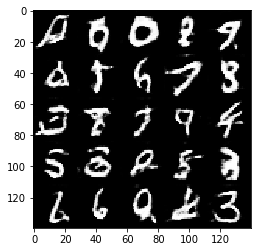

Epoch 2/2... Discriminator Loss: 1.2310... Generator Loss: 0.7479
Epoch 2/2... Discriminator Loss: 0.8446... Generator Loss: 1.2399
Epoch 2/2... Discriminator Loss: 0.8652... Generator Loss: 1.0951
Epoch 2/2... Discriminator Loss: 1.2165... Generator Loss: 0.7791
Epoch 2/2... Discriminator Loss: 0.7477... Generator Loss: 1.5112
Epoch 2/2... Discriminator Loss: 0.9512... Generator Loss: 1.0637
Epoch 2/2... Discriminator Loss: 1.8902... Generator Loss: 0.3329
Epoch 2/2... Discriminator Loss: 0.8489... Generator Loss: 1.6856
Epoch 2/2... Discriminator Loss: 0.8298... Generator Loss: 1.4253
Epoch 2/2... Discriminator Loss: 1.4610... Generator Loss: 0.5340


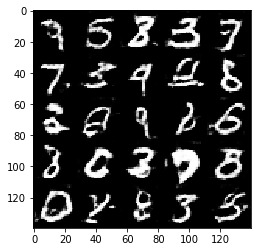

Epoch 2/2... Discriminator Loss: 0.7862... Generator Loss: 1.5506
Epoch 2/2... Discriminator Loss: 0.8515... Generator Loss: 1.2529
Epoch 2/2... Discriminator Loss: 1.2670... Generator Loss: 0.6349
Epoch 2/2... Discriminator Loss: 0.8963... Generator Loss: 1.3561
Epoch 2/2... Discriminator Loss: 0.9436... Generator Loss: 1.0387
Epoch 2/2... Discriminator Loss: 0.8476... Generator Loss: 1.2331
Epoch 2/2... Discriminator Loss: 0.9046... Generator Loss: 1.4757
Epoch 2/2... Discriminator Loss: 0.7898... Generator Loss: 1.4609
Epoch 2/2... Discriminator Loss: 0.7220... Generator Loss: 1.5456
Epoch 2/2... Discriminator Loss: 0.8549... Generator Loss: 1.7292


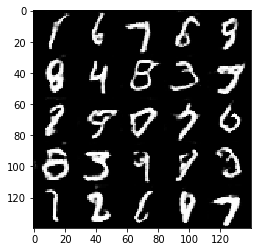

Epoch 2/2... Discriminator Loss: 1.0657... Generator Loss: 0.9410
Epoch 2/2... Discriminator Loss: 0.7458... Generator Loss: 1.4855
Epoch 2/2... Discriminator Loss: 0.7606... Generator Loss: 1.5944
Epoch 2/2... Discriminator Loss: 0.7159... Generator Loss: 1.5912
Epoch 2/2... Discriminator Loss: 0.9840... Generator Loss: 0.9696
Epoch 2/2... Discriminator Loss: 1.5092... Generator Loss: 0.5435
Epoch 2/2... Discriminator Loss: 1.0038... Generator Loss: 0.9487
Epoch 2/2... Discriminator Loss: 0.9436... Generator Loss: 1.3601
Epoch 2/2... Discriminator Loss: 0.9357... Generator Loss: 1.2171
Epoch 2/2... Discriminator Loss: 0.8387... Generator Loss: 1.8363


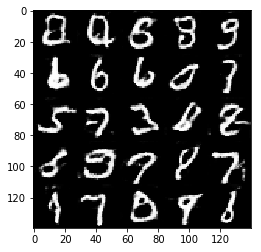

Epoch 2/2... Discriminator Loss: 0.7537... Generator Loss: 1.7329
Epoch 2/2... Discriminator Loss: 0.8478... Generator Loss: 1.4338
Epoch 2/2... Discriminator Loss: 0.8189... Generator Loss: 1.2991
Epoch 2/2... Discriminator Loss: 0.8315... Generator Loss: 1.3300
Epoch 2/2... Discriminator Loss: 1.0433... Generator Loss: 0.9211
Epoch 2/2... Discriminator Loss: 0.8785... Generator Loss: 1.9466
Epoch 2/2... Discriminator Loss: 0.8918... Generator Loss: 1.2089
Epoch 2/2... Discriminator Loss: 1.0274... Generator Loss: 2.0174
Epoch 2/2... Discriminator Loss: 0.8991... Generator Loss: 1.4459
Epoch 2/2... Discriminator Loss: 0.8695... Generator Loss: 1.1909


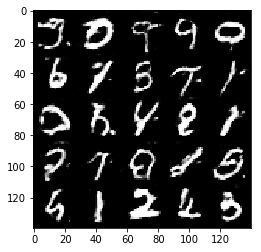

Epoch 2/2... Discriminator Loss: 0.7257... Generator Loss: 1.9569
Epoch 2/2... Discriminator Loss: 0.8547... Generator Loss: 1.5215
Epoch 2/2... Discriminator Loss: 0.9294... Generator Loss: 1.0899
Epoch 2/2... Discriminator Loss: 1.1658... Generator Loss: 0.7831
Epoch 2/2... Discriminator Loss: 0.8365... Generator Loss: 1.1922
Epoch 2/2... Discriminator Loss: 0.6874... Generator Loss: 1.8047
Epoch 2/2... Discriminator Loss: 0.7669... Generator Loss: 1.3638
Epoch 2/2... Discriminator Loss: 0.7501... Generator Loss: 1.8635
Epoch 2/2... Discriminator Loss: 0.8190... Generator Loss: 1.3743
Epoch 2/2... Discriminator Loss: 0.7276... Generator Loss: 1.5849


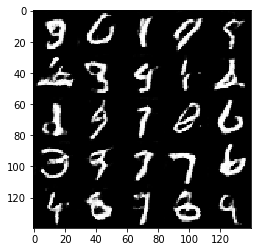

Epoch 2/2... Discriminator Loss: 0.7742... Generator Loss: 1.4658
Epoch 2/2... Discriminator Loss: 1.0972... Generator Loss: 3.6405
Epoch 2/2... Discriminator Loss: 1.7250... Generator Loss: 0.3986
Epoch 2/2... Discriminator Loss: 1.2212... Generator Loss: 2.0292
Epoch 2/2... Discriminator Loss: 0.7650... Generator Loss: 1.8707
Epoch 2/2... Discriminator Loss: 0.7835... Generator Loss: 1.3236
Epoch 2/2... Discriminator Loss: 0.8250... Generator Loss: 1.2935
Epoch 2/2... Discriminator Loss: 0.8239... Generator Loss: 1.2706
Epoch 2/2... Discriminator Loss: 0.8911... Generator Loss: 1.1357
Epoch 2/2... Discriminator Loss: 0.9895... Generator Loss: 1.1315


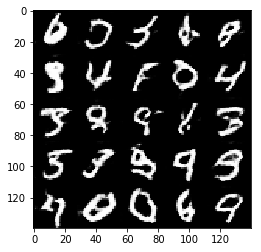

Epoch 2/2... Discriminator Loss: 0.8023... Generator Loss: 2.2326
Epoch 2/2... Discriminator Loss: 1.0888... Generator Loss: 0.8895
Epoch 2/2... Discriminator Loss: 0.7431... Generator Loss: 1.5727
Epoch 2/2... Discriminator Loss: 0.9371... Generator Loss: 2.1314
Epoch 2/2... Discriminator Loss: 0.6927... Generator Loss: 1.6580
Epoch 2/2... Discriminator Loss: 0.8107... Generator Loss: 1.3076
Epoch 2/2... Discriminator Loss: 2.1735... Generator Loss: 4.6418
Epoch 2/2... Discriminator Loss: 0.9925... Generator Loss: 1.0113
Epoch 2/2... Discriminator Loss: 0.8020... Generator Loss: 1.9047
Epoch 2/2... Discriminator Loss: 0.7440... Generator Loss: 1.5198


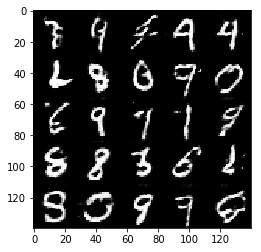

Epoch 2/2... Discriminator Loss: 1.2375... Generator Loss: 0.7579
Epoch 2/2... Discriminator Loss: 0.7791... Generator Loss: 1.4084
Epoch 2/2... Discriminator Loss: 0.8402... Generator Loss: 1.3732
Epoch 2/2... Discriminator Loss: 0.9116... Generator Loss: 1.1684
Epoch 2/2... Discriminator Loss: 0.7669... Generator Loss: 1.4207
Epoch 2/2... Discriminator Loss: 0.7687... Generator Loss: 1.6136
Epoch 2/2... Discriminator Loss: 0.6596... Generator Loss: 1.7530
Epoch 2/2... Discriminator Loss: 0.8941... Generator Loss: 1.0870
Epoch 2/2... Discriminator Loss: 0.7267... Generator Loss: 1.6482
Epoch 2/2... Discriminator Loss: 1.1491... Generator Loss: 0.9265


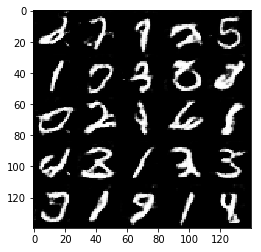

Epoch 2/2... Discriminator Loss: 0.7571... Generator Loss: 1.5491
Epoch 2/2... Discriminator Loss: 0.6181... Generator Loss: 2.0390
Epoch 2/2... Discriminator Loss: 0.7273... Generator Loss: 1.6385
Epoch 2/2... Discriminator Loss: 0.9660... Generator Loss: 1.0321
Epoch 2/2... Discriminator Loss: 0.9483... Generator Loss: 1.0841
Epoch 2/2... Discriminator Loss: 0.7256... Generator Loss: 1.7210
Epoch 2/2... Discriminator Loss: 0.9894... Generator Loss: 1.0120
Epoch 2/2... Discriminator Loss: 0.6892... Generator Loss: 1.6451
Epoch 2/2... Discriminator Loss: 0.8111... Generator Loss: 1.2745
Epoch 2/2... Discriminator Loss: 0.9202... Generator Loss: 1.6027


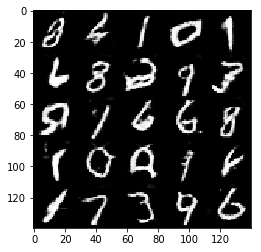

Epoch 2/2... Discriminator Loss: 0.7432... Generator Loss: 1.7820
Epoch 2/2... Discriminator Loss: 0.8747... Generator Loss: 1.1813
Epoch 2/2... Discriminator Loss: 0.6846... Generator Loss: 1.7339
Epoch 2/2... Discriminator Loss: 0.9392... Generator Loss: 1.0011
Epoch 2/2... Discriminator Loss: 0.8255... Generator Loss: 1.3923
Epoch 2/2... Discriminator Loss: 0.9216... Generator Loss: 1.5720
Epoch 2/2... Discriminator Loss: 0.7532... Generator Loss: 1.7533
Epoch 2/2... Discriminator Loss: 0.8645... Generator Loss: 1.2585
Epoch 2/2... Discriminator Loss: 1.0677... Generator Loss: 0.9019
Epoch 2/2... Discriminator Loss: 1.0590... Generator Loss: 0.8844


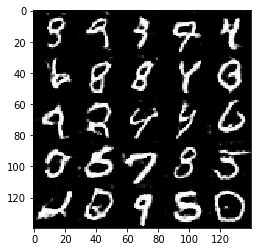

Epoch 2/2... Discriminator Loss: 0.9315... Generator Loss: 1.0888
Epoch 2/2... Discriminator Loss: 0.9659... Generator Loss: 0.9824
Epoch 2/2... Discriminator Loss: 0.7870... Generator Loss: 1.4753
Epoch 2/2... Discriminator Loss: 1.2725... Generator Loss: 0.7333
Epoch 2/2... Discriminator Loss: 2.1355... Generator Loss: 4.7095
Epoch 2/2... Discriminator Loss: 0.6404... Generator Loss: 2.4908
Epoch 2/2... Discriminator Loss: 0.6607... Generator Loss: 2.1032
Epoch 2/2... Discriminator Loss: 0.8631... Generator Loss: 1.2409
Epoch 2/2... Discriminator Loss: 0.7947... Generator Loss: 1.3755
Epoch 2/2... Discriminator Loss: 0.7910... Generator Loss: 1.3887


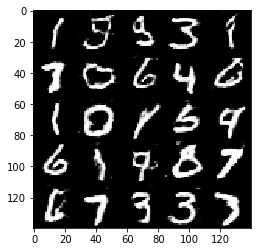

Epoch 2/2... Discriminator Loss: 0.7462... Generator Loss: 1.4674
Epoch 2/2... Discriminator Loss: 0.7874... Generator Loss: 1.3010
Epoch 2/2... Discriminator Loss: 0.8346... Generator Loss: 1.1839
Epoch 2/2... Discriminator Loss: 1.1635... Generator Loss: 2.3004
Epoch 2/2... Discriminator Loss: 0.7802... Generator Loss: 1.5436
Epoch 2/2... Discriminator Loss: 0.7421... Generator Loss: 1.6677
Epoch 2/2... Discriminator Loss: 0.8126... Generator Loss: 1.2465
Epoch 2/2... Discriminator Loss: 0.7339... Generator Loss: 1.5667
Epoch 2/2... Discriminator Loss: 0.8371... Generator Loss: 1.9014
Epoch 2/2... Discriminator Loss: 0.7087... Generator Loss: 1.7971


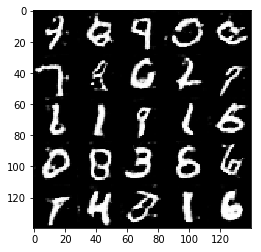

Epoch 2/2... Discriminator Loss: 0.9948... Generator Loss: 1.1275
Epoch 2/2... Discriminator Loss: 0.8886... Generator Loss: 1.2012
Epoch 2/2... Discriminator Loss: 1.1130... Generator Loss: 0.8282
Epoch 2/2... Discriminator Loss: 1.5732... Generator Loss: 0.5902
Epoch 2/2... Discriminator Loss: 0.9987... Generator Loss: 3.0086
Epoch 2/2... Discriminator Loss: 0.9323... Generator Loss: 1.1669
Epoch 2/2... Discriminator Loss: 0.8698... Generator Loss: 1.1499
Epoch 2/2... Discriminator Loss: 0.6914... Generator Loss: 1.7366
Epoch 2/2... Discriminator Loss: 0.7364... Generator Loss: 2.6882
Epoch 2/2... Discriminator Loss: 0.8759... Generator Loss: 1.2272


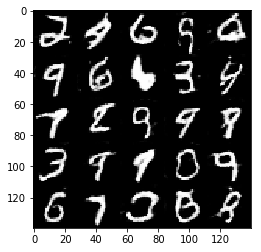

Epoch 2/2... Discriminator Loss: 0.8230... Generator Loss: 1.3487
Epoch 2/2... Discriminator Loss: 0.7950... Generator Loss: 1.4566
Epoch 2/2... Discriminator Loss: 0.6380... Generator Loss: 1.9296
Epoch 2/2... Discriminator Loss: 0.8105... Generator Loss: 1.4079
Epoch 2/2... Discriminator Loss: 0.9323... Generator Loss: 1.0502
Epoch 2/2... Discriminator Loss: 1.7524... Generator Loss: 0.4432
Epoch 2/2... Discriminator Loss: 0.8032... Generator Loss: 1.2711
Epoch 2/2... Discriminator Loss: 0.7185... Generator Loss: 1.5254
Epoch 2/2... Discriminator Loss: 1.3664... Generator Loss: 0.5973
Epoch 2/2... Discriminator Loss: 0.6522... Generator Loss: 1.9876


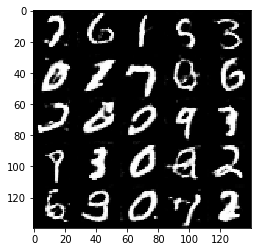

Epoch 2/2... Discriminator Loss: 1.4507... Generator Loss: 0.5284
Epoch 2/2... Discriminator Loss: 0.9520... Generator Loss: 1.0879
Epoch 2/2... Discriminator Loss: 0.8148... Generator Loss: 1.2598
Epoch 2/2... Discriminator Loss: 0.7204... Generator Loss: 1.6283
Epoch 2/2... Discriminator Loss: 0.6492... Generator Loss: 1.8536
Epoch 2/2... Discriminator Loss: 0.8976... Generator Loss: 1.1805
Epoch 2/2... Discriminator Loss: 0.9977... Generator Loss: 1.1024
Epoch 2/2... Discriminator Loss: 0.9807... Generator Loss: 0.9626
Epoch 2/2... Discriminator Loss: 1.1041... Generator Loss: 0.8113
Epoch 2/2... Discriminator Loss: 0.9937... Generator Loss: 1.0201


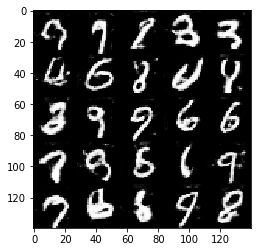

Epoch 2/2... Discriminator Loss: 0.7433... Generator Loss: 1.9441
Epoch 2/2... Discriminator Loss: 0.7639... Generator Loss: 1.8368
Epoch 2/2... Discriminator Loss: 0.8056... Generator Loss: 1.3738
Epoch 2/2... Discriminator Loss: 0.6332... Generator Loss: 1.9525
Epoch 2/2... Discriminator Loss: 0.7034... Generator Loss: 1.7198
Final Output


RuntimeError: Attempted to use a closed Session.

In [12]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 6.1916... Generator Loss: 0.0031


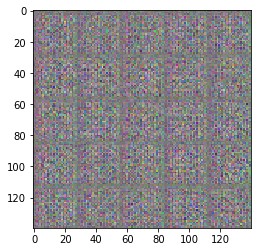

Epoch 1/1... Discriminator Loss: 2.6624... Generator Loss: 0.1152
Epoch 1/1... Discriminator Loss: 2.8740... Generator Loss: 0.1539
Epoch 1/1... Discriminator Loss: 1.8867... Generator Loss: 5.0581
Epoch 1/1... Discriminator Loss: 1.6834... Generator Loss: 2.1118
Epoch 1/1... Discriminator Loss: 2.1837... Generator Loss: 3.2164
Epoch 1/1... Discriminator Loss: 1.5671... Generator Loss: 2.0565
Epoch 1/1... Discriminator Loss: 1.1231... Generator Loss: 0.7039
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.5571
Epoch 1/1... Discriminator Loss: 1.8769... Generator Loss: 4.4207
Epoch 1/1... Discriminator Loss: 1.3768... Generator Loss: 2.5691


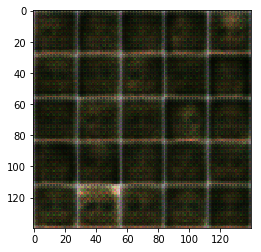

Epoch 1/1... Discriminator Loss: 1.0082... Generator Loss: 3.5661
Epoch 1/1... Discriminator Loss: 1.5282... Generator Loss: 0.3754
Epoch 1/1... Discriminator Loss: 0.6439... Generator Loss: 1.3930
Epoch 1/1... Discriminator Loss: 1.2025... Generator Loss: 1.5867
Epoch 1/1... Discriminator Loss: 0.7381... Generator Loss: 1.7511
Epoch 1/1... Discriminator Loss: 3.2163... Generator Loss: 0.0655
Epoch 1/1... Discriminator Loss: 1.8094... Generator Loss: 0.2771
Epoch 1/1... Discriminator Loss: 1.3073... Generator Loss: 2.0273
Epoch 1/1... Discriminator Loss: 1.1310... Generator Loss: 2.3772
Epoch 1/1... Discriminator Loss: 1.2444... Generator Loss: 1.5891


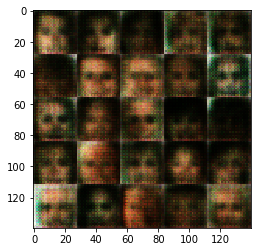

Epoch 1/1... Discriminator Loss: 0.5400... Generator Loss: 2.0719
Epoch 1/1... Discriminator Loss: 1.4897... Generator Loss: 4.0242
Epoch 1/1... Discriminator Loss: 0.8030... Generator Loss: 0.9988
Epoch 1/1... Discriminator Loss: 2.3242... Generator Loss: 0.1391
Epoch 1/1... Discriminator Loss: 2.0926... Generator Loss: 0.1945
Epoch 1/1... Discriminator Loss: 0.6478... Generator Loss: 1.7769
Epoch 1/1... Discriminator Loss: 0.5575... Generator Loss: 1.6586
Epoch 1/1... Discriminator Loss: 0.4734... Generator Loss: 1.7277
Epoch 1/1... Discriminator Loss: 1.6384... Generator Loss: 1.7601
Epoch 1/1... Discriminator Loss: 2.5769... Generator Loss: 0.1163


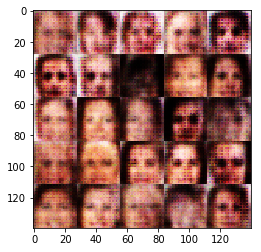

Epoch 1/1... Discriminator Loss: 0.8321... Generator Loss: 1.0999
Epoch 1/1... Discriminator Loss: 1.5187... Generator Loss: 1.4895
Epoch 1/1... Discriminator Loss: 2.9354... Generator Loss: 0.0877
Epoch 1/1... Discriminator Loss: 1.8939... Generator Loss: 0.2516
Epoch 1/1... Discriminator Loss: 2.2897... Generator Loss: 0.1572
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 0.9998... Generator Loss: 0.8110
Epoch 1/1... Discriminator Loss: 2.2962... Generator Loss: 0.1676
Epoch 1/1... Discriminator Loss: 1.1141... Generator Loss: 0.6361
Epoch 1/1... Discriminator Loss: 0.7680... Generator Loss: 0.9851


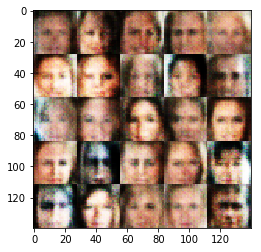

Epoch 1/1... Discriminator Loss: 1.4002... Generator Loss: 0.6166
Epoch 1/1... Discriminator Loss: 0.8536... Generator Loss: 1.8139
Epoch 1/1... Discriminator Loss: 1.0520... Generator Loss: 2.9200
Epoch 1/1... Discriminator Loss: 1.4579... Generator Loss: 1.3057
Epoch 1/1... Discriminator Loss: 1.7989... Generator Loss: 0.2663
Epoch 1/1... Discriminator Loss: 2.2260... Generator Loss: 0.1624
Epoch 1/1... Discriminator Loss: 1.6519... Generator Loss: 0.2924
Epoch 1/1... Discriminator Loss: 1.7536... Generator Loss: 0.3130
Epoch 1/1... Discriminator Loss: 1.2745... Generator Loss: 0.5070
Epoch 1/1... Discriminator Loss: 1.5984... Generator Loss: 0.3177


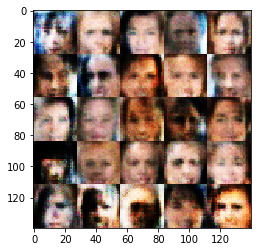

Epoch 1/1... Discriminator Loss: 1.8522... Generator Loss: 0.2382
Epoch 1/1... Discriminator Loss: 0.7575... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 0.8785... Generator Loss: 2.1761
Epoch 1/1... Discriminator Loss: 0.4962... Generator Loss: 3.1849
Epoch 1/1... Discriminator Loss: 0.5222... Generator Loss: 3.8460
Epoch 1/1... Discriminator Loss: 0.3970... Generator Loss: 2.4492
Epoch 1/1... Discriminator Loss: 0.2865... Generator Loss: 3.5596
Epoch 1/1... Discriminator Loss: 0.5448... Generator Loss: 1.3762
Epoch 1/1... Discriminator Loss: 0.7875... Generator Loss: 0.9841
Epoch 1/1... Discriminator Loss: 0.3312... Generator Loss: 3.6815


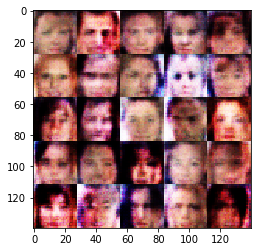

Epoch 1/1... Discriminator Loss: 0.7419... Generator Loss: 5.9086
Epoch 1/1... Discriminator Loss: 1.1121... Generator Loss: 3.9447
Epoch 1/1... Discriminator Loss: 0.6802... Generator Loss: 1.0448
Epoch 1/1... Discriminator Loss: 0.4599... Generator Loss: 5.8211
Epoch 1/1... Discriminator Loss: 0.4452... Generator Loss: 5.1826
Epoch 1/1... Discriminator Loss: 0.2426... Generator Loss: 3.8925
Epoch 1/1... Discriminator Loss: 0.7132... Generator Loss: 1.1294
Epoch 1/1... Discriminator Loss: 0.5727... Generator Loss: 5.4819
Epoch 1/1... Discriminator Loss: 0.4345... Generator Loss: 1.8814
Epoch 1/1... Discriminator Loss: 1.2915... Generator Loss: 0.4687


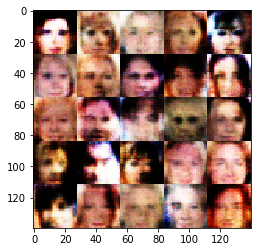

Epoch 1/1... Discriminator Loss: 0.3357... Generator Loss: 4.3638
Epoch 1/1... Discriminator Loss: 0.4264... Generator Loss: 1.7273
Epoch 1/1... Discriminator Loss: 0.3027... Generator Loss: 2.4595
Epoch 1/1... Discriminator Loss: 0.5820... Generator Loss: 1.3258
Epoch 1/1... Discriminator Loss: 0.2897... Generator Loss: 3.0715
Epoch 1/1... Discriminator Loss: 0.2931... Generator Loss: 2.5993
Epoch 1/1... Discriminator Loss: 0.2660... Generator Loss: 2.9359
Epoch 1/1... Discriminator Loss: 0.3856... Generator Loss: 4.9943
Epoch 1/1... Discriminator Loss: 2.2533... Generator Loss: 2.9965
Epoch 1/1... Discriminator Loss: 0.3608... Generator Loss: 4.8542


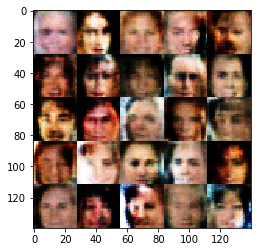

Epoch 1/1... Discriminator Loss: 0.4059... Generator Loss: 3.8457
Epoch 1/1... Discriminator Loss: 0.2272... Generator Loss: 5.0013
Epoch 1/1... Discriminator Loss: 0.4387... Generator Loss: 5.0311
Epoch 1/1... Discriminator Loss: 0.9292... Generator Loss: 6.0887
Epoch 1/1... Discriminator Loss: 0.4696... Generator Loss: 6.0409
Epoch 1/1... Discriminator Loss: 0.6844... Generator Loss: 6.9041
Epoch 1/1... Discriminator Loss: 0.4855... Generator Loss: 4.1903
Epoch 1/1... Discriminator Loss: 0.3100... Generator Loss: 3.9601
Epoch 1/1... Discriminator Loss: 0.2502... Generator Loss: 5.1583
Epoch 1/1... Discriminator Loss: 0.2286... Generator Loss: 5.2404


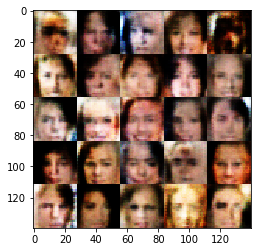

Epoch 1/1... Discriminator Loss: 0.2994... Generator Loss: 3.3173
Epoch 1/1... Discriminator Loss: 0.3346... Generator Loss: 2.2814
Epoch 1/1... Discriminator Loss: 0.2213... Generator Loss: 4.4198
Epoch 1/1... Discriminator Loss: 1.0815... Generator Loss: 4.6502
Epoch 1/1... Discriminator Loss: 0.3024... Generator Loss: 3.0508
Epoch 1/1... Discriminator Loss: 0.3267... Generator Loss: 2.2903
Epoch 1/1... Discriminator Loss: 0.5475... Generator Loss: 5.4028
Epoch 1/1... Discriminator Loss: 0.6170... Generator Loss: 5.7053
Epoch 1/1... Discriminator Loss: 0.2490... Generator Loss: 3.2880
Epoch 1/1... Discriminator Loss: 0.3144... Generator Loss: 2.3034


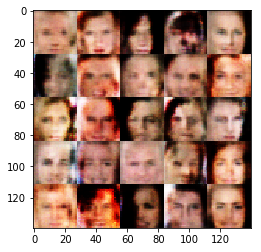

Epoch 1/1... Discriminator Loss: 0.4107... Generator Loss: 6.2466
Epoch 1/1... Discriminator Loss: 0.2311... Generator Loss: 5.6178
Epoch 1/1... Discriminator Loss: 0.2461... Generator Loss: 3.3804
Epoch 1/1... Discriminator Loss: 0.2668... Generator Loss: 3.1687
Epoch 1/1... Discriminator Loss: 0.2396... Generator Loss: 3.1905
Epoch 1/1... Discriminator Loss: 0.2183... Generator Loss: 4.4864
Epoch 1/1... Discriminator Loss: 0.6191... Generator Loss: 7.6817
Epoch 1/1... Discriminator Loss: 0.2914... Generator Loss: 2.8339
Epoch 1/1... Discriminator Loss: 0.2315... Generator Loss: 3.5506
Epoch 1/1... Discriminator Loss: 0.2044... Generator Loss: 5.5185


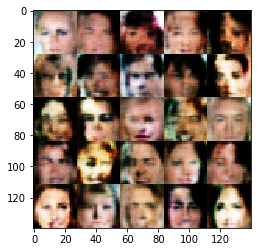

Epoch 1/1... Discriminator Loss: 0.9534... Generator Loss: 5.2134
Epoch 1/1... Discriminator Loss: 0.3160... Generator Loss: 2.4583
Epoch 1/1... Discriminator Loss: 0.2468... Generator Loss: 4.1850
Epoch 1/1... Discriminator Loss: 0.1977... Generator Loss: 4.5283
Epoch 1/1... Discriminator Loss: 0.2313... Generator Loss: 3.2768
Epoch 1/1... Discriminator Loss: 2.2263... Generator Loss: 0.1864
Epoch 1/1... Discriminator Loss: 0.8150... Generator Loss: 0.9404
Epoch 1/1... Discriminator Loss: 0.2882... Generator Loss: 2.7425
Epoch 1/1... Discriminator Loss: 0.2620... Generator Loss: 4.0822
Epoch 1/1... Discriminator Loss: 0.2768... Generator Loss: 2.7664


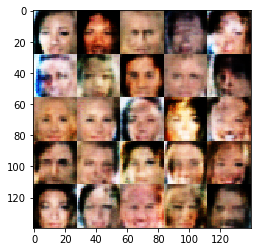

Epoch 1/1... Discriminator Loss: 0.2082... Generator Loss: 4.1084
Epoch 1/1... Discriminator Loss: 0.2028... Generator Loss: 4.3913
Epoch 1/1... Discriminator Loss: 0.2479... Generator Loss: 2.9954
Epoch 1/1... Discriminator Loss: 0.2042... Generator Loss: 5.9588
Epoch 1/1... Discriminator Loss: 0.3401... Generator Loss: 5.7480
Epoch 1/1... Discriminator Loss: 0.8184... Generator Loss: 5.5098
Epoch 1/1... Discriminator Loss: 2.6767... Generator Loss: 2.8939
Epoch 1/1... Discriminator Loss: 0.3376... Generator Loss: 3.8448
Epoch 1/1... Discriminator Loss: 0.2801... Generator Loss: 3.1443
Epoch 1/1... Discriminator Loss: 0.3454... Generator Loss: 3.5482


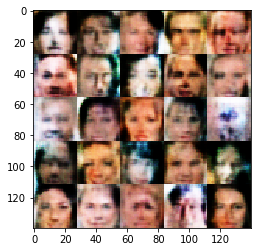

Epoch 1/1... Discriminator Loss: 0.2104... Generator Loss: 4.4284
Epoch 1/1... Discriminator Loss: 0.3122... Generator Loss: 4.6382
Epoch 1/1... Discriminator Loss: 0.2218... Generator Loss: 3.6897
Epoch 1/1... Discriminator Loss: 0.2688... Generator Loss: 2.9092
Epoch 1/1... Discriminator Loss: 0.2079... Generator Loss: 4.2569
Epoch 1/1... Discriminator Loss: 0.2224... Generator Loss: 3.6330
Epoch 1/1... Discriminator Loss: 0.7425... Generator Loss: 5.3256
Epoch 1/1... Discriminator Loss: 0.2474... Generator Loss: 6.0066
Epoch 1/1... Discriminator Loss: 3.0702... Generator Loss: 5.2190
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 3.1710


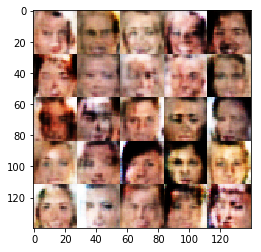

Epoch 1/1... Discriminator Loss: 0.2723... Generator Loss: 4.0951
Epoch 1/1... Discriminator Loss: 0.3870... Generator Loss: 5.4583
Epoch 1/1... Discriminator Loss: 0.4457... Generator Loss: 3.6167
Epoch 1/1... Discriminator Loss: 0.3022... Generator Loss: 4.1554
Epoch 1/1... Discriminator Loss: 0.2465... Generator Loss: 5.2055
Epoch 1/1... Discriminator Loss: 0.2606... Generator Loss: 4.0433
Epoch 1/1... Discriminator Loss: 0.2084... Generator Loss: 4.2137
Epoch 1/1... Discriminator Loss: 0.7580... Generator Loss: 4.7108
Epoch 1/1... Discriminator Loss: 0.9775... Generator Loss: 2.6065
Epoch 1/1... Discriminator Loss: 0.2742... Generator Loss: 4.4019


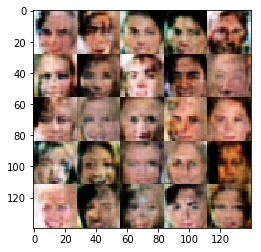

Epoch 1/1... Discriminator Loss: 0.2137... Generator Loss: 3.8896
Epoch 1/1... Discriminator Loss: 2.8565... Generator Loss: 4.1935
Epoch 1/1... Discriminator Loss: 0.2936... Generator Loss: 3.2770
Epoch 1/1... Discriminator Loss: 0.2508... Generator Loss: 4.1331
Epoch 1/1... Discriminator Loss: 0.2889... Generator Loss: 2.5234
Epoch 1/1... Discriminator Loss: 0.2487... Generator Loss: 3.0697
Epoch 1/1... Discriminator Loss: 0.2281... Generator Loss: 3.4024
Epoch 1/1... Discriminator Loss: 0.2187... Generator Loss: 5.2144
Epoch 1/1... Discriminator Loss: 0.2715... Generator Loss: 2.6099
Epoch 1/1... Discriminator Loss: 0.2564... Generator Loss: 3.8817


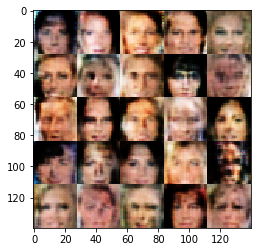

Epoch 1/1... Discriminator Loss: 0.2159... Generator Loss: 3.6507
Epoch 1/1... Discriminator Loss: 0.2808... Generator Loss: 2.7542
Epoch 1/1... Discriminator Loss: 0.8994... Generator Loss: 1.9810
Epoch 1/1... Discriminator Loss: 0.2535... Generator Loss: 3.4670
Epoch 1/1... Discriminator Loss: 0.2061... Generator Loss: 4.7023
Epoch 1/1... Discriminator Loss: 0.3006... Generator Loss: 2.4023
Epoch 1/1... Discriminator Loss: 1.5877... Generator Loss: 0.3858
Epoch 1/1... Discriminator Loss: 0.2234... Generator Loss: 3.9077
Epoch 1/1... Discriminator Loss: 0.2477... Generator Loss: 3.2949
Epoch 1/1... Discriminator Loss: 0.5348... Generator Loss: 1.4500


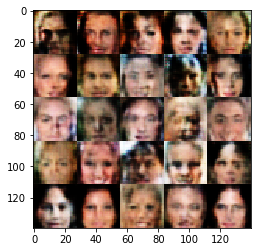

Epoch 1/1... Discriminator Loss: 0.1980... Generator Loss: 5.3759
Epoch 1/1... Discriminator Loss: 0.2205... Generator Loss: 4.4067
Epoch 1/1... Discriminator Loss: 0.4569... Generator Loss: 5.1432
Epoch 1/1... Discriminator Loss: 0.6285... Generator Loss: 4.5961
Epoch 1/1... Discriminator Loss: 0.2490... Generator Loss: 3.0642
Epoch 1/1... Discriminator Loss: 0.2922... Generator Loss: 5.2713
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 6.3616
Epoch 1/1... Discriminator Loss: 0.6380... Generator Loss: 3.8239
Epoch 1/1... Discriminator Loss: 0.2189... Generator Loss: 4.8507
Epoch 1/1... Discriminator Loss: 0.9879... Generator Loss: 3.2671


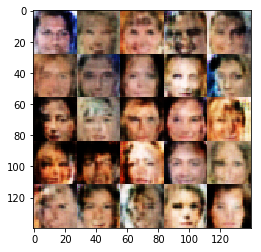

Epoch 1/1... Discriminator Loss: 0.4747... Generator Loss: 5.1478
Epoch 1/1... Discriminator Loss: 0.2910... Generator Loss: 3.8685
Epoch 1/1... Discriminator Loss: 0.2021... Generator Loss: 4.3571
Epoch 1/1... Discriminator Loss: 0.2898... Generator Loss: 2.5204
Epoch 1/1... Discriminator Loss: 0.2761... Generator Loss: 5.5289
Epoch 1/1... Discriminator Loss: 0.2043... Generator Loss: 4.2008
Epoch 1/1... Discriminator Loss: 0.3290... Generator Loss: 6.3381
Epoch 1/1... Discriminator Loss: 2.7947... Generator Loss: 3.2196
Epoch 1/1... Discriminator Loss: 0.4739... Generator Loss: 3.8582
Epoch 1/1... Discriminator Loss: 0.2523... Generator Loss: 3.5733


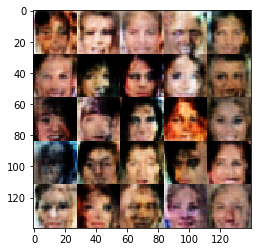

Epoch 1/1... Discriminator Loss: 0.6317... Generator Loss: 1.1428
Epoch 1/1... Discriminator Loss: 0.2643... Generator Loss: 2.7597
Epoch 1/1... Discriminator Loss: 0.3379... Generator Loss: 2.1433
Epoch 1/1... Discriminator Loss: 0.2031... Generator Loss: 4.4579
Epoch 1/1... Discriminator Loss: 0.2164... Generator Loss: 4.5908
Epoch 1/1... Discriminator Loss: 0.3748... Generator Loss: 1.9293
Epoch 1/1... Discriminator Loss: 0.4911... Generator Loss: 1.5806
Epoch 1/1... Discriminator Loss: 0.2431... Generator Loss: 5.0823
Epoch 1/1... Discriminator Loss: 0.2258... Generator Loss: 4.0243
Epoch 1/1... Discriminator Loss: 2.6391... Generator Loss: 4.0511


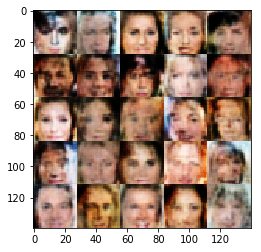

Epoch 1/1... Discriminator Loss: 0.3311... Generator Loss: 2.6422
Epoch 1/1... Discriminator Loss: 0.3396... Generator Loss: 2.1975
Epoch 1/1... Discriminator Loss: 0.3403... Generator Loss: 3.2935
Epoch 1/1... Discriminator Loss: 0.2114... Generator Loss: 5.4181
Epoch 1/1... Discriminator Loss: 1.3914... Generator Loss: 4.4268
Epoch 1/1... Discriminator Loss: 0.3122... Generator Loss: 2.5853
Epoch 1/1... Discriminator Loss: 0.2876... Generator Loss: 3.4188
Epoch 1/1... Discriminator Loss: 0.2972... Generator Loss: 2.5559
Epoch 1/1... Discriminator Loss: 0.1984... Generator Loss: 4.6872
Epoch 1/1... Discriminator Loss: 0.2468... Generator Loss: 4.6860


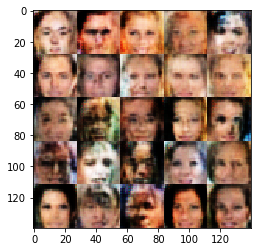

Epoch 1/1... Discriminator Loss: 0.2322... Generator Loss: 4.9734
Epoch 1/1... Discriminator Loss: 0.4543... Generator Loss: 1.9792
Epoch 1/1... Discriminator Loss: 0.6294... Generator Loss: 1.1342
Epoch 1/1... Discriminator Loss: 0.2170... Generator Loss: 3.6709
Epoch 1/1... Discriminator Loss: 0.2409... Generator Loss: 3.2799
Epoch 1/1... Discriminator Loss: 1.5416... Generator Loss: 0.3793
Epoch 1/1... Discriminator Loss: 0.6777... Generator Loss: 3.9442
Epoch 1/1... Discriminator Loss: 0.2626... Generator Loss: 2.9974
Epoch 1/1... Discriminator Loss: 0.2140... Generator Loss: 3.8025
Epoch 1/1... Discriminator Loss: 0.3206... Generator Loss: 2.3441


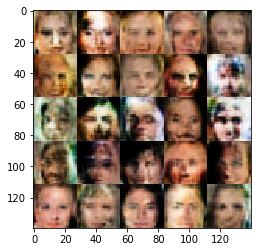

Epoch 1/1... Discriminator Loss: 0.2158... Generator Loss: 3.5823
Epoch 1/1... Discriminator Loss: 0.2225... Generator Loss: 3.8650
Epoch 1/1... Discriminator Loss: 0.2263... Generator Loss: 4.7959
Epoch 1/1... Discriminator Loss: 0.2515... Generator Loss: 3.0679
Epoch 1/1... Discriminator Loss: 0.2151... Generator Loss: 4.9261
Epoch 1/1... Discriminator Loss: 0.2446... Generator Loss: 3.7223
Epoch 1/1... Discriminator Loss: 0.3336... Generator Loss: 6.3807
Epoch 1/1... Discriminator Loss: 0.2198... Generator Loss: 3.8117
Epoch 1/1... Discriminator Loss: 3.2385... Generator Loss: 0.0612
Epoch 1/1... Discriminator Loss: 0.9227... Generator Loss: 0.8440


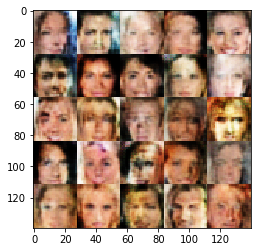

Epoch 1/1... Discriminator Loss: 0.2094... Generator Loss: 4.3073
Epoch 1/1... Discriminator Loss: 1.0708... Generator Loss: 0.5977
Epoch 1/1... Discriminator Loss: 1.6201... Generator Loss: 2.5072
Epoch 1/1... Discriminator Loss: 0.3305... Generator Loss: 2.3970
Epoch 1/1... Discriminator Loss: 0.3523... Generator Loss: 2.2344
Epoch 1/1... Discriminator Loss: 0.3885... Generator Loss: 2.0000
Epoch 1/1... Discriminator Loss: 0.2404... Generator Loss: 3.1246
Epoch 1/1... Discriminator Loss: 1.1965... Generator Loss: 4.9429
Epoch 1/1... Discriminator Loss: 0.3666... Generator Loss: 3.2823
Epoch 1/1... Discriminator Loss: 0.2187... Generator Loss: 4.2083


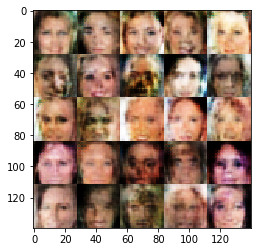

Epoch 1/1... Discriminator Loss: 0.3610... Generator Loss: 2.7978
Epoch 1/1... Discriminator Loss: 0.2780... Generator Loss: 2.7076
Epoch 1/1... Discriminator Loss: 0.2565... Generator Loss: 3.0068
Epoch 1/1... Discriminator Loss: 0.8762... Generator Loss: 4.1530
Epoch 1/1... Discriminator Loss: 1.0497... Generator Loss: 1.4754
Epoch 1/1... Discriminator Loss: 0.4961... Generator Loss: 1.4539
Epoch 1/1... Discriminator Loss: 5.0512... Generator Loss: 6.6845
Epoch 1/1... Discriminator Loss: 0.8319... Generator Loss: 0.9048
Epoch 1/1... Discriminator Loss: 0.4395... Generator Loss: 4.4377
Epoch 1/1... Discriminator Loss: 0.2972... Generator Loss: 2.5384


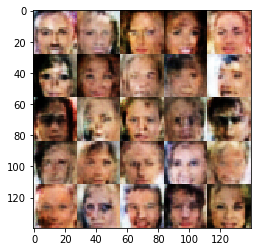

Epoch 1/1... Discriminator Loss: 0.2245... Generator Loss: 3.5081
Epoch 1/1... Discriminator Loss: 0.7336... Generator Loss: 1.0232
Epoch 1/1... Discriminator Loss: 0.3439... Generator Loss: 2.4077
Epoch 1/1... Discriminator Loss: 0.2220... Generator Loss: 4.9584
Epoch 1/1... Discriminator Loss: 0.2631... Generator Loss: 2.9208
Epoch 1/1... Discriminator Loss: 0.2181... Generator Loss: 3.7859
Epoch 1/1... Discriminator Loss: 0.3061... Generator Loss: 3.9603
Epoch 1/1... Discriminator Loss: 0.3219... Generator Loss: 3.1525
Epoch 1/1... Discriminator Loss: 0.3149... Generator Loss: 4.6152
Epoch 1/1... Discriminator Loss: 1.5825... Generator Loss: 0.3233


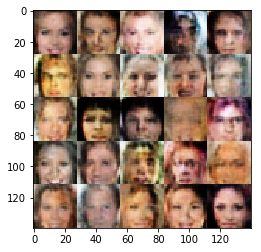

Epoch 1/1... Discriminator Loss: 0.9994... Generator Loss: 0.8729
Epoch 1/1... Discriminator Loss: 0.2910... Generator Loss: 2.5413
Epoch 1/1... Discriminator Loss: 0.2334... Generator Loss: 3.3069
Epoch 1/1... Discriminator Loss: 0.2771... Generator Loss: 3.6596
Epoch 1/1... Discriminator Loss: 0.2294... Generator Loss: 4.3469
Epoch 1/1... Discriminator Loss: 0.2750... Generator Loss: 2.7955
Epoch 1/1... Discriminator Loss: 3.4282... Generator Loss: 0.0586
Epoch 1/1... Discriminator Loss: 0.2762... Generator Loss: 2.7001
Epoch 1/1... Discriminator Loss: 0.3492... Generator Loss: 2.1111
Epoch 1/1... Discriminator Loss: 1.3582... Generator Loss: 0.4810


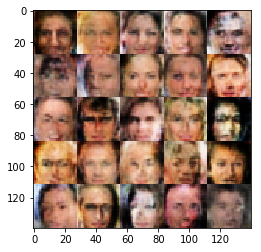

Epoch 1/1... Discriminator Loss: 0.5263... Generator Loss: 1.9953
Epoch 1/1... Discriminator Loss: 1.0065... Generator Loss: 0.7667
Epoch 1/1... Discriminator Loss: 0.4575... Generator Loss: 1.6359
Epoch 1/1... Discriminator Loss: 0.3186... Generator Loss: 2.3750
Epoch 1/1... Discriminator Loss: 1.3882... Generator Loss: 0.4514
Epoch 1/1... Discriminator Loss: 0.5428... Generator Loss: 1.6022
Epoch 1/1... Discriminator Loss: 0.3571... Generator Loss: 2.1284
Epoch 1/1... Discriminator Loss: 0.5420... Generator Loss: 3.6533
Epoch 1/1... Discriminator Loss: 0.4375... Generator Loss: 1.7757
Epoch 1/1... Discriminator Loss: 0.1933... Generator Loss: 5.3172


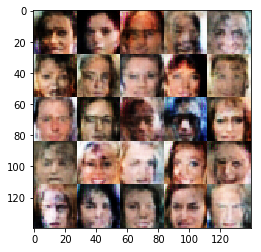

Epoch 1/1... Discriminator Loss: 0.2825... Generator Loss: 2.6976
Epoch 1/1... Discriminator Loss: 0.2831... Generator Loss: 2.5245
Epoch 1/1... Discriminator Loss: 0.5339... Generator Loss: 1.3982
Epoch 1/1... Discriminator Loss: 0.8043... Generator Loss: 0.9544
Epoch 1/1... Discriminator Loss: 0.4706... Generator Loss: 1.6035
Epoch 1/1... Discriminator Loss: 0.2740... Generator Loss: 3.1932
Epoch 1/1... Discriminator Loss: 0.3881... Generator Loss: 1.9183
Epoch 1/1... Discriminator Loss: 0.5859... Generator Loss: 2.7993
Epoch 1/1... Discriminator Loss: 0.7288... Generator Loss: 1.0759
Epoch 1/1... Discriminator Loss: 0.2819... Generator Loss: 2.9769


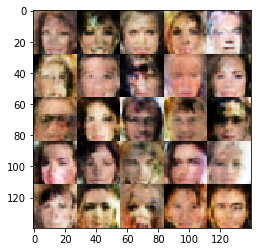

Epoch 1/1... Discriminator Loss: 1.3063... Generator Loss: 0.4635
Epoch 1/1... Discriminator Loss: 0.3424... Generator Loss: 2.8308
Epoch 1/1... Discriminator Loss: 0.2215... Generator Loss: 3.5247
Epoch 1/1... Discriminator Loss: 0.2594... Generator Loss: 2.9377
Epoch 1/1... Discriminator Loss: 0.1931... Generator Loss: 5.3003
Epoch 1/1... Discriminator Loss: 0.2354... Generator Loss: 3.2986
Epoch 1/1... Discriminator Loss: 1.1629... Generator Loss: 1.7432
Epoch 1/1... Discriminator Loss: 1.6043... Generator Loss: 0.3361
Epoch 1/1... Discriminator Loss: 0.5552... Generator Loss: 2.3101
Epoch 1/1... Discriminator Loss: 0.3004... Generator Loss: 2.5670


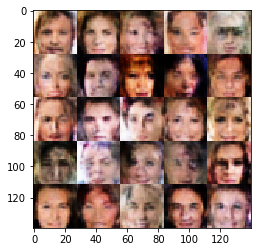

Epoch 1/1... Discriminator Loss: 2.0467... Generator Loss: 0.1869
Epoch 1/1... Discriminator Loss: 0.4771... Generator Loss: 1.6042
Epoch 1/1... Discriminator Loss: 0.3122... Generator Loss: 4.0795
Epoch 1/1... Discriminator Loss: 0.4822... Generator Loss: 1.5635
Epoch 1/1... Discriminator Loss: 2.4209... Generator Loss: 4.4714
Epoch 1/1... Discriminator Loss: 0.2754... Generator Loss: 4.7835
Epoch 1/1... Discriminator Loss: 0.3696... Generator Loss: 2.0496
Epoch 1/1... Discriminator Loss: 0.2774... Generator Loss: 2.5945
Epoch 1/1... Discriminator Loss: 0.2438... Generator Loss: 2.9805
Epoch 1/1... Discriminator Loss: 0.4504... Generator Loss: 1.5981


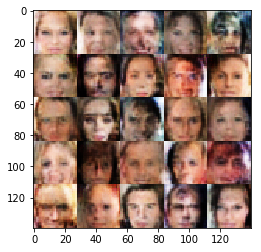

Epoch 1/1... Discriminator Loss: 0.2850... Generator Loss: 4.2140
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 2.7816
Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 0.7266
Epoch 1/1... Discriminator Loss: 0.3433... Generator Loss: 2.2770
Epoch 1/1... Discriminator Loss: 1.1511... Generator Loss: 0.5572
Epoch 1/1... Discriminator Loss: 0.2897... Generator Loss: 3.9892
Epoch 1/1... Discriminator Loss: 0.2796... Generator Loss: 2.7789
Epoch 1/1... Discriminator Loss: 0.2716... Generator Loss: 2.7497
Epoch 1/1... Discriminator Loss: 0.4095... Generator Loss: 1.7697
Epoch 1/1... Discriminator Loss: 0.2894... Generator Loss: 4.5010


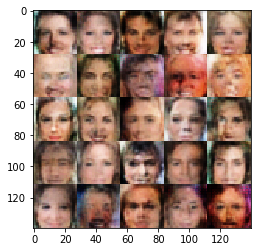

Epoch 1/1... Discriminator Loss: 0.5636... Generator Loss: 2.1253
Epoch 1/1... Discriminator Loss: 0.6214... Generator Loss: 4.0447
Epoch 1/1... Discriminator Loss: 0.4444... Generator Loss: 3.3126
Epoch 1/1... Discriminator Loss: 0.2537... Generator Loss: 3.3805


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.